In [2]:
# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from extract.overlap import TrpzOverlap
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.

### Matplotlib defaults

In [3]:
%matplotlib inline

In [4]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Load simu

In [5]:
from simulation_utils import load_simu

In [6]:
simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_gaussker_notilt.fits")
data = simu["data"]

# Load ref files

In [7]:
from simulation_utils import GaussKer

In [9]:
path = "../jwst-mtl/SOSS/extract/Ref_files/"

# List of orders to consider in the extraction
order_list = [1, 2]

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata(path + "wavelengths_m1.fits"))
wave_maps.append(fits.getdata(path + "wavelengths_m2.fits"))

# Remove the tilt from wv maps
wave_maps[0] = np.tile(wave_maps[0][50,:], (256, 1))
wave_maps[1] = np.tile(wave_maps[1][50,:], (256, 1))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata(path + "spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata(path + "spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]

#### Convolution kernels ####
# ker_list = [WebbKer(wv_map) for wv_map in wave_maps]
ker_list = [GaussKer(simu["grid"], res) for res in [2000, 900]]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [10]:
params = {}

# Map of expected noise (standard deviation).
bkgd_noise = 20.  # In counts?

# Wavelength extraction grid oversampling.
params["n_os"] = 3  # TODO explain a bit more how the grid is determined?
# Answer: I was thinking of explaining all inputs in another notebook or text?
#         Since this parameter is needed for every extraction, I didn't want
#         to re-explain it in all examples. What do you think?

# Threshold on the spatial profile. 
# Only pixels above this threshold will be used for extraction.
# (for at least one order)
params["thresh"] = 1e-4  # Same units as the spatial profiles

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [11]:
extract = TrpzOverlap(*ref_files_args, c_kwargs={'thresh':1e-6}, **params)

### Test different types of tikhonov matrix by finding the best logl

In [ ]:
from extract.regularisation import 

In [28]:
extract.get_tikho_tests(factors_init, tikho_kwargs={'t_mat':'second'}, data=data, sig=sig)

Testing factors...
14/14


{'factors': array([1.00000000e-30, 2.42446202e-29, 5.87801607e-28, 1.42510267e-26,
        3.45510729e-25, 8.37677640e-24, 2.03091762e-22, 4.92388263e-21,
        1.19377664e-19, 2.89426612e-18, 7.01703829e-17, 1.70125428e-15,
        4.12462638e-14, 1.00000000e-12]),
 'solution': array([[4.68781761e+17, 4.68321386e+17, 4.67861011e+17, ...,
         3.76277396e+14, 1.99434501e+14, 7.02417451e+13],
        [4.65601481e+17, 4.65263476e+17, 4.64925471e+17, ...,
         3.76160579e+14, 1.99370262e+14, 7.02183889e+13],
        [4.61573848e+17, 4.61264582e+17, 4.60955315e+17, ...,
         3.60173624e+14, 1.90590987e+14, 6.70300963e+13],
        ...,
        [9.89944255e+05, 9.89863002e+05, 9.89781749e+05, ...,
         7.69411493e-01, 3.84791009e-01, 1.28288112e-01],
        [1.24570472e+03, 1.24560394e+03, 1.24550316e+03, ...,
         1.07672003e-03, 5.38492596e-04, 1.79536158e-04],
        [2.22514705e+00, 2.22496867e+00, 2.22479029e+00, ...,
         1.90771513e-06, 9.54088128e-07, 3.1

Testing factors...
20/20
Testing factors...
20/20
Testing factors...
20/20


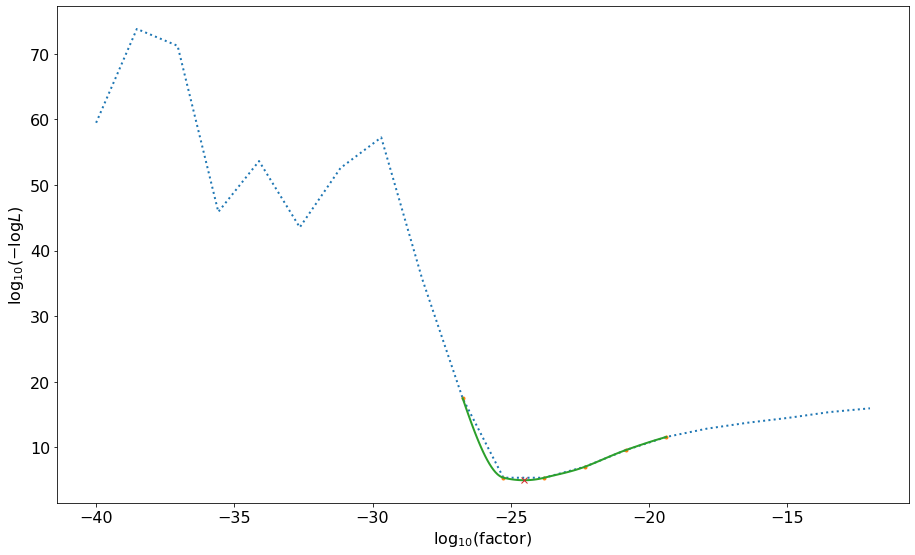

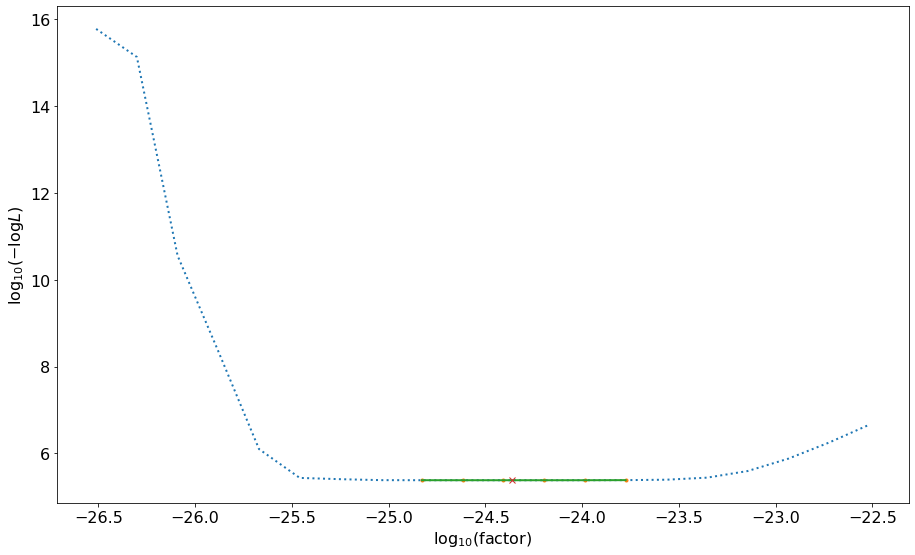

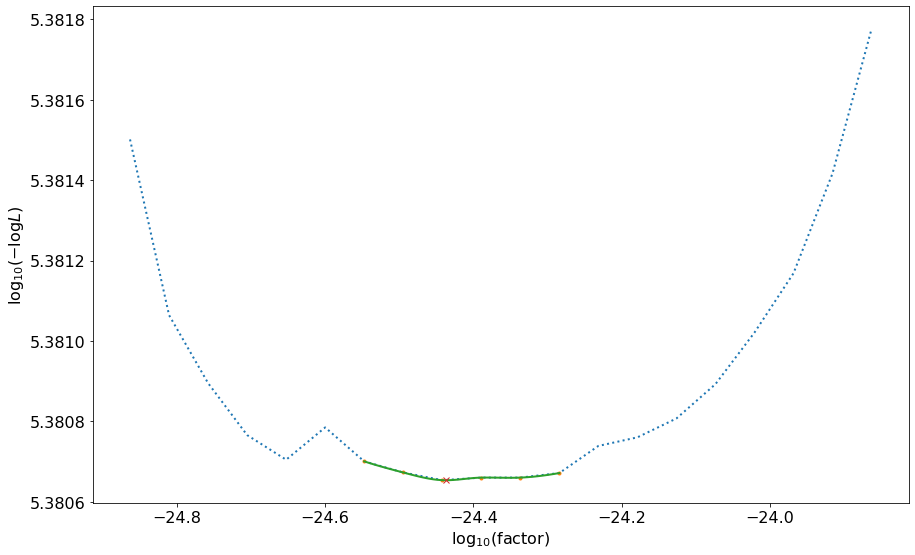

In [46]:
# Determine which factors to tests.
factors_init = np.logspace(-40, -12, 20)

# Noise estimate to weigh the pixels.
# Poisson noise + background noise.
sig = np.sqrt(data + bkgd_noise**2)

tikho_type = [None, {'t_mat':'second'}]

### Get best logl ###

tikho_kwargs = tikho_type[0]

# Tests all these factors.
tests = extract.get_tikho_tests(factors_init, tikho_kwargs=tikho_kwargs, data=data, sig=sig)

# Find the best factor.
plt.figure()
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

tests = extract.get_tikho_tests(factors, tikho_kwargs=tikho_kwargs, data=data, sig=sig)

# Find the best factor.
plt.figure()
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

# Refine again the grid (span 1 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-0.5, best_fac+0.5, 20)

tests = extract.get_tikho_tests(factors, tikho_kwargs=tikho_kwargs, data=data, sig=sig)

# Find the best factor.
plt.figure()
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

### Compare result to injected spectrum

In [47]:
f_k = extract(data=data, sig=sig, p_list=spat_pros, tikhonov=True, tikho_kwargs=tikho_kwargs, factor=best_fac)
# f_k = extract(data=data, sig=sig, p_list=spat_pros)

In [48]:
rebuilt = extract.rebuild(f_k)

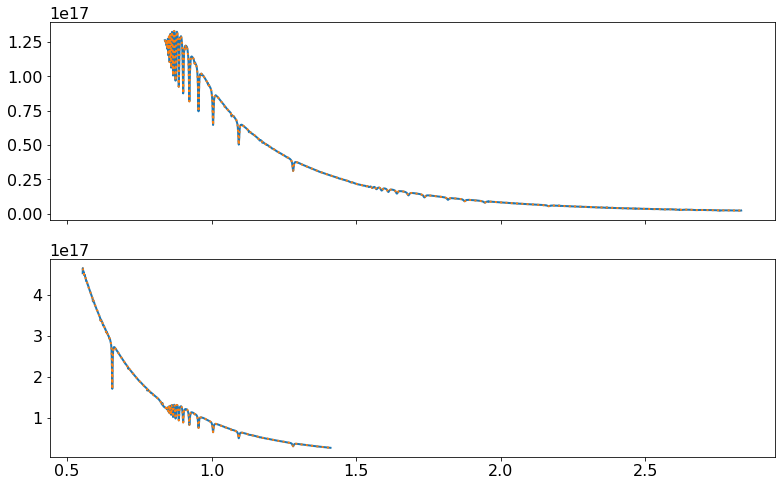

In [49]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(extract.lam_grid_c(0), extract.c_list[0].dot(f_k))
ax[0].plot('grid_c1', 'f_c1', ":", data=simu)

ax[1].plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
ax[1].plot('grid_c2', 'f_c2', ":", data=simu)

In [50]:
from scipy.interpolate import interp1d

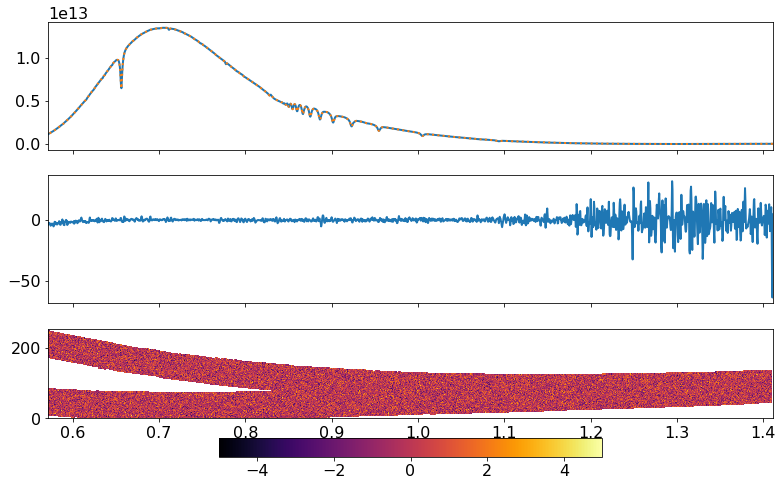

In [51]:
fig, ax = plt.subplots(3, 1, sharex=True)

grid_bin, f_bin = extract.bin_to_pixel(f_k_c=extract.c_list[1].dot(f_k),
                                       grid_pix=wave_maps[1][100,:1800],
                                       grid_f_k=extract.lam_grid_c(1), i_ord=1)
_, f_bin_th = extract.bin_to_pixel(f_k_c=simu['f_c2'], grid_pix=grid_bin, grid_f_k=simu['grid_c2'], i_ord=1)

ax[0].plot(grid_bin, f_bin)
ax[0].plot(grid_bin, f_bin_th, ":")

# f_th_interp = interp1d(simu['grid_c2'], simu['f_c2'], kind='cubic', bounds_error=False, fill_value=np.nan)
ax[1].plot(grid_bin, (f_bin-f_bin_th)/f_bin_th*1e6)

im = ax[-1].pcolormesh(wave_maps[1][100,:1800], np.arange(256), ((rebuilt-data)/sig)[:, :1800], vmin=-5, vmax=5)
# plt.imshow((rebuilt-data)/sig, vmin=-5, vmax=5., interpolation=None)
plt.colorbar(im, ax=ax[-1], orientation="horizontal")